<a href="https://colab.research.google.com/github/meghanadhsai/PINNS-MJ/blob/main/2D_DeepXDE_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepxde --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.2/184.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.6 MB/s eta 0:00:00


Compiling model...
Building feed-forward neural network...
'build' took 0.168112 s

'compile' took 2.010515 s

Training model...

0         [3.27e-02, 9.01e-01, 2.83e-02, 9.26e-03, 1.85e-02]    [3.27e-02, 9.01e-01, 2.83e-02, 9.26e-03, 1.85e-02]    []  
1000      [2.60e-03, 4.79e-02, 2.86e-03, 1.69e-02, 2.34e-02]    [2.60e-03, 4.79e-02, 2.86e-03, 1.69e-02, 2.34e-02]    []  
2000      [2.57e-03, 4.87e-02, 1.33e-03, 1.35e-02, 1.97e-02]    [2.57e-03, 4.87e-02, 1.33e-03, 1.35e-02, 1.97e-02]    []  
3000      [2.88e-03, 4.55e-02, 8.45e-04, 1.24e-02, 1.85e-02]    [2.88e-03, 4.55e-02, 8.45e-04, 1.24e-02, 1.85e-02]    []  
4000      [2.49e-03, 3.84e-02, 3.97e-04, 1.09e-02, 1.82e-02]    [2.49e-03, 3.84e-02, 3.97e-04, 1.09e-02, 1.82e-02]    []  
5000      [5.59e-03, 2.87e-02, 1.83e-04, 1.14e-02, 1.88e-02]    [5.59e-03, 2.87e-02, 1.83e-04, 1.14e-02, 1.88e-02]    []  
6000      [5.77e-03, 2.41e-02, 4.79e-04, 8.92e-03, 1.53e-02]    [5.77e-03, 2.41e-02, 4.79e-04, 8.92e-03, 1.53e-02]    []  
7000     

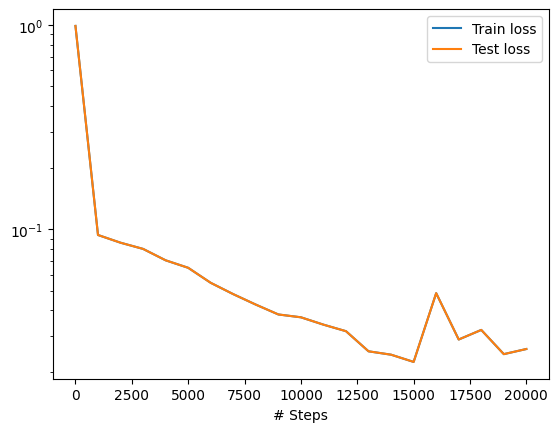

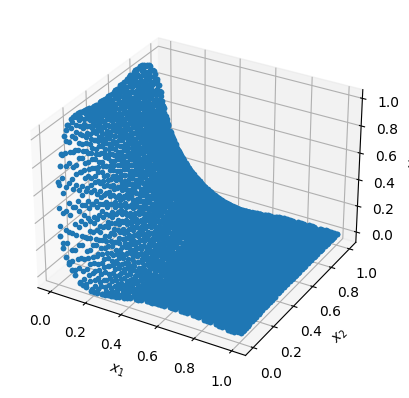

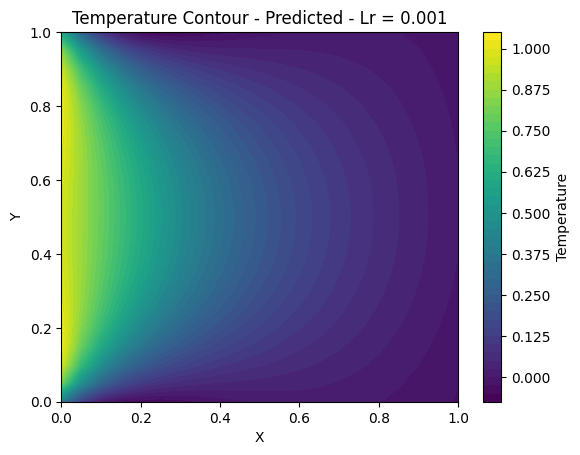

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import torch

# Define the PDE function (2D heat conduction equation)
def pde(x, y):
    T = y
    T_x = dde.grad.jacobian(y, x, i=0, j=0)
    T_y = dde.grad.jacobian(y, x, i=0, j=1)
    T_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    T_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)

    return T_xx + T_yy

# Define the boundary condition functions
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

def boundary_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)

def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], 1)

# Left boundary condition T = 1
bc_left = dde.DirichletBC(geom, lambda x: 1, boundary_left)

# Other boundary conditions T = 0
bc_right = dde.DirichletBC(geom, lambda x: 0, boundary_right)
bc_bottom = dde.DirichletBC(geom, lambda x: 0, boundary_bottom)
bc_top = dde.DirichletBC(geom, lambda x: 0, boundary_top)

# Define geometry for the domain (square)
geom = dde.geometry.geometry_2d.Rectangle([0, 0], [1, 1])

# Combine boundary conditions
bcs = [bc_left, bc_right, bc_bottom, bc_top]

# Define the data for the problem (PDE and BCs)
data = dde.data.PDE(geom, pde, bcs, num_domain=4000, num_boundary=200)

# Define the neural network model (8 hidden layers, 20 neurons)
net = dde.maps.FNN([2] + [20] * 8 + [1], "tanh", "Glorot uniform")

# Define the model
model = dde.Model(data, net)

# Set up training parameters
model.compile("adam", lr=1e-3)

# Train the model
losshistory, train_state = model.train(epochs=20000)

# Plot the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Create grid for plotting
x_coor = np.linspace(0, 1, 21)
y_coor = np.linspace(0, 1, 21)
X, Y = np.meshgrid(x_coor, y_coor)
points = np.vstack((X.flatten(), Y.flatten())).T

# Predict temperature distribution
T_test = model.predict(points)
T_test2 = T_test.reshape(X.shape)

# Plot the temperature contour
plt.contourf(X, Y, T_test2, levels=50, cmap='viridis')
plt.colorbar(label='Temperature')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Temperature Contour - Predicted - Lr = ' + str(1e-3))
plt.show()
